<a href="https://colab.research.google.com/github/Mervvick/AI_Autoencoder_Ultra_Pro/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22%D0%91%D0%B0%D0%B7%D0%BE%D0%B2%D1%8B%D0%B9_%D0%B1%D0%BB%D0%BE%D0%BA_%7C_%D0%90%D1%80%D1%85%D0%B8%D1%82%D0%B5%D0%BA%D1%82%D1%83%D1%80%D0%B0_%D0%B0%D0%B2%D1%82%D0%BE%D0%BA%D0%BE%D0%B4%D0%B8%D1%80%D0%BE%D0%B2%D1%89%D0%B8%D0%BA%D0%B0_(Autoencoder)_%7C_%D0%94%D0%97_Ultra_Pro_%7C_%D0%A3%D0%98%D0%98%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Задание

Создайте автокодировщик, удаляющий черные квадраты в лучшайных областях изображений.

Алгоритм действий:
1. Возьмите базу картинок Mnist.
2. На картинках в случайных местах сделайте чёрные квадраты размера 8 на 8.
3. Создайте и обучите автокодировщик восстанавливать оригинальные изображения из "зашумленных" квадратом изображений.
4. Добейтесь MSE < 0.0070 на тестовой выборке

## Импорт библиотек

In [1]:
# Отображение
import matplotlib.pyplot as plt

# Для работы с тензорами
import numpy as np

# Класс создания модели
from tensorflow.keras.models import Model

# Для загрузки данных
from tensorflow.keras.datasets import mnist

# Необходимые слои
from tensorflow.keras.layers import Input, Conv2DTranspose, MaxPooling2D, Conv2D, BatchNormalization, Flatten, Dense, Reshape

# Оптимизатор
from tensorflow.keras.optimizers import Adam

import random

from copy import deepcopy

In [2]:
def plot_images(X, pred, shape=None, n=5):

    # Автоопределение формы данных
    if shape is None:

        # Форма изображения
        shape = X.shape[1:3]

    # Размер полотна
    plt.figure(figsize=(14, 7))

    # Вывод n пар изображений
    for i in range(n):

        # Выбор случайного индекса изображения
        index = np.random.randint(0, pred.shape[0])

        # Показ картинки с индексом index из набора X
        ax = plt.subplot(2, n, i + 1)               # Картинка располагается в верхнем ряду

        # Серая палитра
        plt.imshow(X[index].reshape(shape), cmap='gray')

        # Без отображения числовых осей
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Показ картинки с тем же индексом из предсказания автокодировщика
        ax = plt.subplot(2, n, i + 1 + n)           # Картинка располагается в нижнем ряду

        # Серая палитра
        plt.imshow(pred[index].reshape(shape), cmap='gray')

        # Без отображения числовых осей
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

## Данные

In [3]:
# Загрузка данных
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [4]:
# Нормировка данных
X_train = X_train.astype('float32')/255.
X_test = X_test.astype('float32')/255.

In [5]:
# Изменение формы под удобную для Keras
X_train = X_train.reshape((-1, 28, 28, 1))
X_test = X_test.reshape((-1, 28, 28, 1))

# Черные квадраты

In [6]:
# Ваше решение
X_train.shape

(60000, 28, 28, 1)

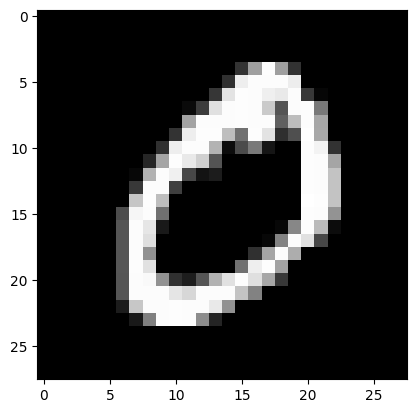

In [7]:
plt.imshow(X_train[1], cmap = 'gray')
plt.show()

In [8]:
a = [1, 2, 3]
b = a[:]
b[1] = 9
print(a, b)

[1, 2, 3] [1, 9, 3]


In [9]:
def squared(data):
  x_train_squared = deepcopy(X_train)
  for img in x_train_squared:
    x = random.randint(0, 20)
    for row in range(x, x + 8):
      img[row][x:x+8] = 0
  return x_train_squared

In [10]:
X_train_squared = squared(X_train)

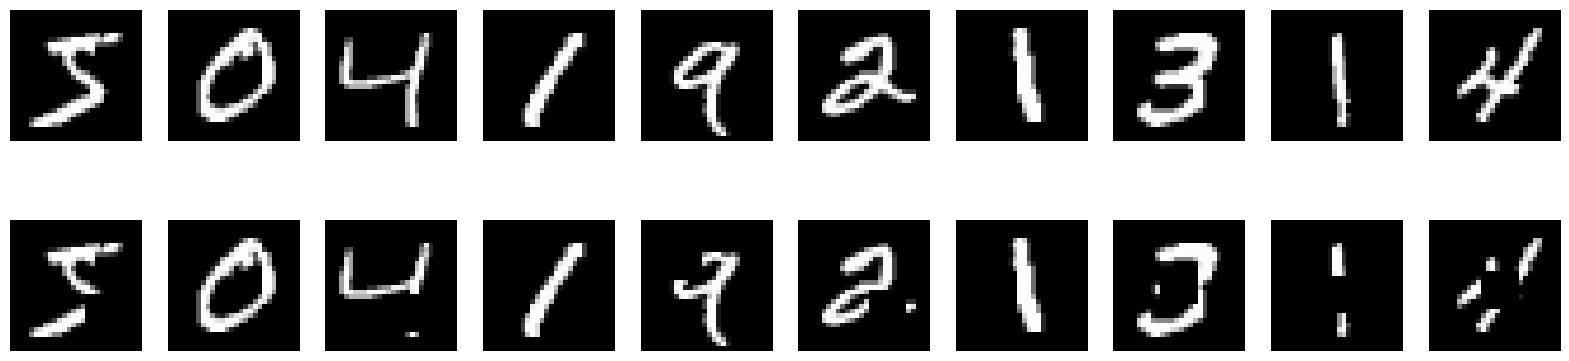

In [11]:
plt.figure(figsize = (20, 5))
for i in range(10):
  axs = plt.subplot(2, 10, i + 1)
  axs.imshow(X_train[i], cmap = 'gray')
  axs.axis('off')

  axs = plt.subplot(2, 10, i + 11)
  axs.imshow(X_train_squared[i], cmap = 'gray')
  axs.axis('off')

plt.show()

In [23]:
X_test_squared = squared(X_test)

# Автокодировщик

In [18]:
encoder_input = Input(X_train.shape[1:]) # 28, 28, 1
x = Conv2D(8, 3, activation = 'relu', padding = 'same', dilation_rate = 2)(encoder_input) # 28, 28, 8
x = BatchNormalization()(x)
x = Conv2D(16, 3, activation = 'relu', padding = 'same', dilation_rate = 2)(x) # 28, 28, 16
x = BatchNormalization()(x)
x = Conv2D(16, 3, activation = 'relu', padding = 'same', strides = 2)(x) # 14, 14, 16
x = BatchNormalization()(x)
x = Conv2D(32, 3, activation = 'relu', padding = 'same')(x) # 14, 14, 32
x = BatchNormalization()(x)
x = Conv2D(64, 3, activation = 'relu', padding = 'same')(x) # 14, 14, 64
x = BatchNormalization()(x)
x = Conv2D(64, 3, activation = 'relu', padding = 'same', strides = 2)(x) # 7, 7, 64
x = BatchNormalization()(x)

pre_flat_shape = x.shape[1:]
x = Flatten()(x) # 3136
flat_shape = x.shape[1]

x = Dense(512)(x)
encoder_output = Dense(64)(x)


decoder_input = Input(64)
x = Dense(512)(decoder_input)
x = Dense(flat_shape)(x)
x = Reshape(pre_flat_shape)(x) # 7, 7, 64
x = Conv2DTranspose(64, 3, activation = 'relu', padding = 'same', strides = 2)(x)# 14, 14, 64
x = BatchNormalization()(x)
x = Conv2D(64, 3, activation = 'relu', padding = 'same')(x) # 14, 14, 64
x = BatchNormalization()(x)
x = Conv2D(32, 3, activation = 'relu', padding = 'same')(x) # 14, 14, 32
x = BatchNormalization()(x)
x = Conv2DTranspose(16, 3, activation = 'relu', padding = 'same', strides = 2)(x)# 28, 28, 16
x = BatchNormalization()(x)
x = Conv2D(16, 3, activation = 'relu', padding = 'same')(x) # 28, 28, 16
x = BatchNormalization()(x)
x = Conv2D(8, 3, activation = 'relu', padding = 'same')(x) # 28, 28, 8
x = BatchNormalization()(x)
decoder_output = Conv2D(1, 3, activation = 'relu', padding = 'same')(x) # 28, 28, 1

encoder = Model(encoder_input, encoder_output)
decoder = Model(decoder_input, decoder_output)

autoencoder = Model(encoder_input, decoder(encoder(encoder_input)))
autoencoder.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 model_6 (Functional)        (None, 64)                1703408   
                                                                 
 model_7 (Functional)        (None, 28, 28, 1)         1743345   
                                                                 
Total params: 3,446,753
Trainable params: 3,445,953
Non-trainable params: 800
_________________________________________________________________


In [19]:
autoencoder.compile(Adam(0.001),
                    loss = 'MSE')

autoencoder.fit(X_train_squared,
                X_train,
                batch_size = 16,
                epochs = 5,
                verbose = 1)

Epoch 1/5
3750/3750 [==============================] - 57s 12ms/step - loss: 0.0203
Epoch 2/5
3750/3750 [==============================] - 47s 12ms/step - loss: 0.0098
Epoch 3/5
3750/3750 [==============================] - 47s 12ms/step - loss: 0.0079
Epoch 4/5
3750/3750 [==============================] - 47s 12ms/step - loss: 0.0066
Epoch 5/5
3750/3750 [==============================] - 47s 12ms/step - loss: 0.0056


1875/1875 [==============================] - 7s 4ms/step


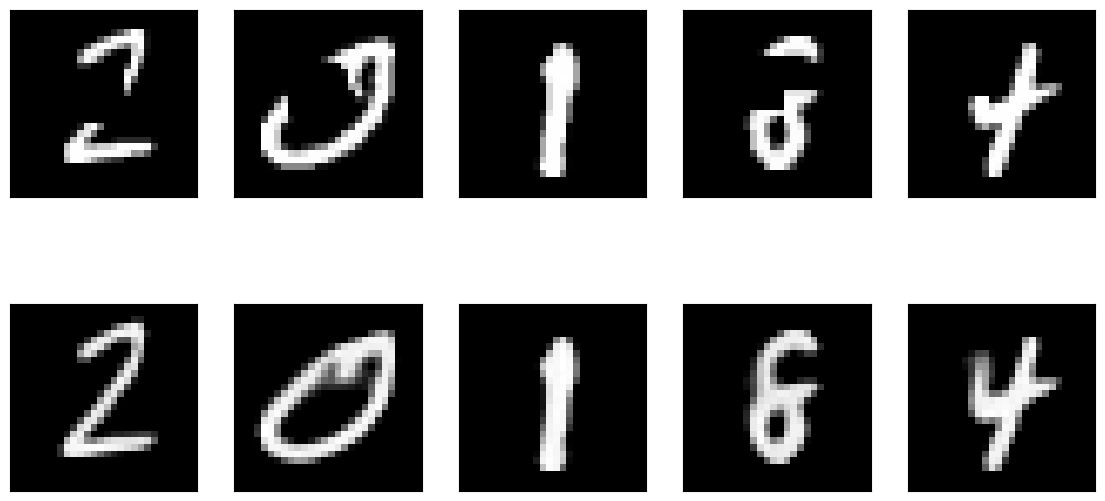

In [28]:
pred = autoencoder.predict(X_test_squared)
plot_images(X_test_squared, pred)

Работает!